Get Data on your Computer without big ckpt files:

    home/woAuchImmer/AML_project$ rsync -azP --exclude "*.ckpt" cluster:AML_project/_trainings/ _trainings/
    
with big ckpt files:
    
    home/woAuchImmer/AML_project$ rsync -azP cluster:AML_project/_trainings/ _trainings/

In [142]:
import numpy as np
import torch
import random
import json

In [143]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

In [144]:
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import ipywidgets as widgets


# latex text in plots
usetex = True
if usetex:
    rc('text', usetex=True)
else:
    rc('text', usetex=False)

#change plt parameter globally 
plt.rcParams.update({'font.size': 18,
                     'xtick.labelsize' : 16,
                     'ytick.labelsize' : 16})

In [145]:
parent = "_trainings"
children = sorted(os.listdir(parent), reverse=True)

In [193]:
widget = widgets.Dropdown(
    options=children,
    description='Directory:',
    disabled=False,
)
widget

Dropdown(description='Directory:', options=('25-09_17-03_aDAOG_cB3D_b24_e200_BN_lr0.01_lrsp10_varUnet_ch32', '…

In [253]:
path = os.path.join(parent, widget.value)
print("Load results from ", path)

Load results from  _trainings/25-09_13-01_aDAOG_cB3D_b24_e200_BN_lrstep100-120-140-160-180


In [254]:
with open(os.path.join(path, "net_config.json")) as dict_file:
    network_config = json.load(dict_file)
print(network_config)

{'network': 'Unet', 'optimizer': 'Adam', 'adam_regul_factor': 0, 'batch_size': 24, 'learning_rate': 0.001, 'use_lr_scheduler': False, 'use_step_lr_scheduler': False, 'lr_steps': [100, 120, 140, 160, 180], 'gamma': 0.1, 'loss': 'BCEandDiceLoss', 'data_trafos': {'class': 'Compose', 'pipeline': [{'class': 'BoundingBoxesToMask'}, {'class': 'NDArrayTo3dTensor'}, {'class': 'randomize.<locals>.DerivedRandomizedTrafo', 'function': 'rotate', 'random_function': 'custom_gauss', 'kwargs': {'angle': [0, 3]}}, {'class': 'randomize.<locals>.DerivedRandomizedTrafo', 'function': 'shear', 'random_function': 'custom_gauss', 'kwargs': {'shear_x': [0, 3], 'shear_y': [0, 3]}}, {'class': 'randomize.<locals>.DerivedRandomizedTrafo', 'function': 'translate', 'random_function': 'custom_gauss', 'kwargs': {'translate_x': [0, 4], 'translate_y': [0, 4]}}, {'class': 'randomize.<locals>.DerivedRandomizedTrafo', 'function': 'scale', 'random_function': 'positive_half_gauss', 'kwargs': {'scale_factor': [1, 0.075]}}]}, '

In [255]:
loss = np.load(os.path.join(path, "loss.npy"))
dce = np.load(os.path.join(path, "dce.npy"))
loss_val = np.load(os.path.join(path, "loss_val.npy"))
dce_val = np.load(os.path.join(path, "dce_val.npy"))

In [256]:
cut_to_100 = False
if cut_to_100:    
    loss = loss[:100]
    dce = dce[:100]
    loss_val = loss_val[:100]
    dce_val = dce_val[:100]

In [257]:
print(np.mean(dce_val[80:100]))
print(np.mean(dce_val[130:]))
print(np.mean(dce_val[180:]))
print("Max Dice score (in steps of 10 epochs) at epoch ", (np.argmax(dce_val[::10])+1)*10, " with ", np.max(dce_val[::10]))

try:
    if network_config["use_lr_scheduler"]:
        print()
        print("LR Scheduler Documentation")
        print(f"Epoch    0: intitialised learning rate of group 0 is {network_config['learning_rate']}.")
        pseudo_optim = torch.optim.Adam([torch.tensor(1)], lr=network_config["learning_rate"])
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pseudo_optim, "min",
                                                               patience=network_config["lr_sch_patience"], verbose=True)
        for epoch in range(1,len(loss_val)):
            scheduler.step(loss_val[epoch])    
except:
    pass

0.5413971761439709
0.5738756072829198
0.5734613464233724
Max Dice score (in steps of 10 epochs) at epoch  130  with  0.577947384499489


Total number of epochs:  200


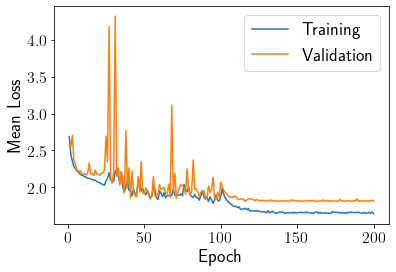

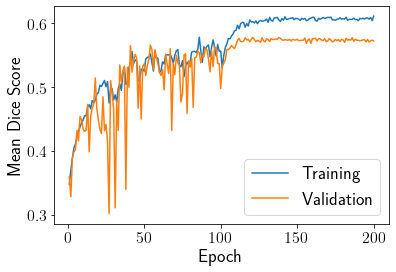

In [258]:
n_ep = len(loss)
epochs = np.arange(1,n_ep+1)
print("Total number of epochs: ", n_ep)
plt.figure()
plt.plot(epochs, loss, label="Training")
plt.plot(epochs, loss_val, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Loss")
plt.show()
plt.figure()
plt.plot(epochs, dce, label="Training")
plt.plot(epochs, dce_val, label="Validation")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Score")
plt.show()

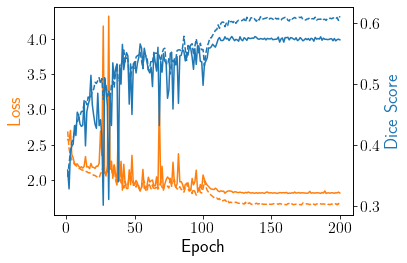

In [259]:
save_image = True

fig, ax1 = plt.subplots()

color = "C1" #'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(epochs, loss, "--", color=color)
ax1.plot(epochs, loss_val, color=color)
#ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(0.2,7)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = "C0" #'tab:blue'
ax2.set_ylabel('Dice Score', color=color)  # we already handled the x-label with ax1
ax2.plot(epochs, dce, "--", color=color)
ax2.plot(epochs, dce_val, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#ax2.set_ylim(0.2,0.7)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
if save_image:
    plt.savefig(f"images/{widget.value}.pdf", bbox_inches='tight')
plt.show()

# Show Predictions

In [260]:
from datasets import LoadDataset, CustomOutput
from datasets.custom_output import image_tensor, float_mask, bounding_boxes
from torch.utils.data import DataLoader, Subset
from trafo.randomize.default_augmentation import default_augmentation_only_geometric

loaded_data = LoadDataset("_data/preprocessed256_new", image_dtype=float,
                          label_dtype=float)

dataset_plain = CustomOutput(loaded_data, image_tensor, float_mask)
dataset_aug = CustomOutput(loaded_data, image_tensor, bounding_boxes, trafo=default_augmentation_only_geometric)

In [261]:
"""# get good split of dataset -> dividable by batch_size
batch_size = 16
l = len(dataset)
x = l // (batch_size *6 )
split = [x * batch_size * 5, l - x * batch_size * 5]
print(split)
train_set, val_set = torch.utils.data.random_split(dataset, split)""";

from sklearn.model_selection import train_test_split

batch_size = 16

# get good split of dataset -> dividable by batch_size
l = len(dataset_aug)
indices = list(range(l))
train_size = (l // (batch_size * 6)) * batch_size * 5
val_size = l - train_size
print("Training: ", train_size, "Validation: ", val_size)
train_indices, val_indices = train_test_split(indices, random_state=4, train_size=train_size, test_size=val_size)

train_set = Subset(dataset_aug, train_indices)
val_set = Subset(dataset_plain, val_indices)

Training:  5200 Validation:  1134


In [262]:
dataloader_train = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=0)#, pin_memory = True)
dataloader_val = DataLoader(val_set, batch_size=batch_size,
                        shuffle=True, num_workers=0, pin_memory = True)

In [263]:
from network.unet import Unet
from network.Model import OurModel
import torch.nn as nn

In [264]:
criterion = nn.BCELoss() # use binary cross entropy loss!
network = Unet(batch_norm=True)

In [267]:
Model = OurModel(name = "unet", network= network, criterion= criterion, path_dir = path, lr = 0.001,
                 verbose = True, segmentation=True, use_cuda=False, data_trafo=dataset_plain.trafo)
Model.load_weights(f"/unet_e130.ckpt")

RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

In [ ]:
for x,y in dataloader_val:
    Model.network.eval()
    y_hat = Model.network(x.float())
    break

y_hat = y_hat.cpu()
y_hat = y_hat.detach().numpy()
y = y.numpy()
fig, ax = plt.subplots(len(y_hat),3, figsize=(10, 100))
for i in range(len(y_hat)):
    ax[i,0].imshow(y_hat[i])
    ax[i,1].imshow(np.round(y_hat[i]))
    ax[i,2].imshow(y.squeeze()[i])